# **Введение**

Дал набор данных для анализа настроений и эмоций — это подобранная коллекция текстовых данных, которая позволяет вникнуть в тонкости человеческих эмоций и чувств, встроенных в текст. Этот набор данных, сочетающий в себе крупномасштабное эмоциональное разнообразие и категоризацию настроений, предлагает богатую площадку для создания современных моделей машинного и глубокого обучения.

# 1.Импорт необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from zipfile import ZipFile
import json


# 2.Загрузка данных (из моего гугл диска)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with ZipFile('/content/drive/MyDrive/archive.zip', 'r') as f:
  f.extractall('/content/sample_data')

## emotion_data

In [ ]:
emotion_data = pd.read_csv("/content/sample_data/archive/combined_emotion.csv")
sentiment_data = pd.read_csv("/content/sample_data/archive/combined_sentiment_data.csv")

In [ ]:
emotion_data.head()

,sentence,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear


In [ ]:
emotion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422746 entries, 0 to 422745
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  422746 non-null  object
 1   emotion   422746 non-null  object
dtypes: object(2)
memory usage: 6.5+ MB


In [ ]:
emotion_data.isnull().sum()

,0
sentence,0
emotion,0


## sentiment_data

In [ ]:
sentiment_data.head()

,sentence,sentiment
0,So there is no way for me to plug it in here i...,negative
1,"Good case, Excellent value.",positive
2,Great for the jawbone.,positive
3,Tied to charger for conversations lasting more...,negative
4,The mic is great.,positive


In [ ]:
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3309 entries, 0 to 3308
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   3309 non-null   object
 1   sentiment  3309 non-null   object
dtypes: object(2)
memory usage: 51.8+ KB


In [ ]:
sentiment_data.isnull().sum()

,0
sentence,0
sentiment,0


In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Оборачиваем функцию в FunctionTransformer
text_preprocessor = FunctionTransformer(lambda x: [preprocess_text(text) for text in x])


# 3.Визуализация распределения классов (bar chart)

In [ ]:
def plot_class_distribution(data, target_column, title):
    plt.figure(figsize=(8, 5))
    sns.countplot(y=data[target_column], order=data[target_column].value_counts().index, hue=data[target_column], palette="pastel")
    plt.title(title)
    plt.xlabel("Количество примеров")
    plt.ylabel("Классы")
    plt.show()


Визуализация распределения классов в датасетах

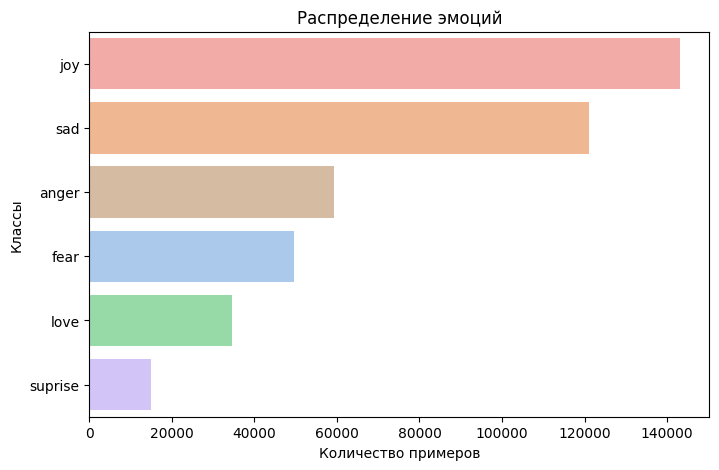

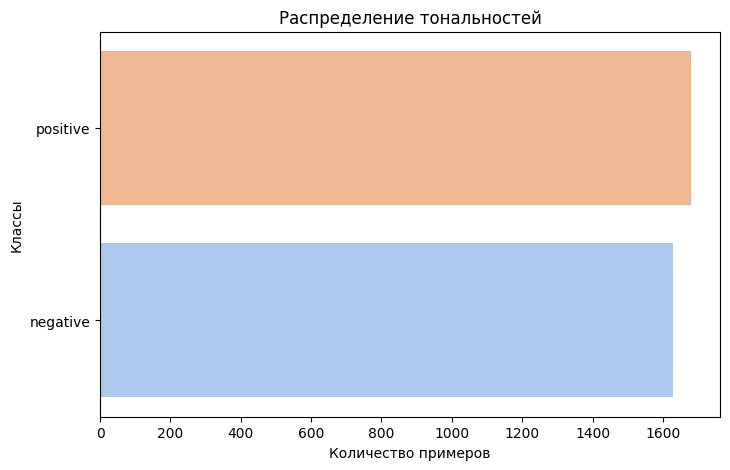

In [ ]:
plot_class_distribution(emotion_data, 'emotion', "Распределение эмоций")
plot_class_distribution(sentiment_data, 'sentiment', "Распределение тональностей")


**Вывод:** Наиболее популярная эмоция - joy. Это радует! На втором и третьем месте -  sad и anger соответственно ( 😰 )
Позитивных тональностей в целом больше, чем негативных, но отрыв небольшой.

# 4.Построение пайплайна и обучение моделей

Функция для обучения моделей классификации, которая разделяет данные на тренировочную и тестовую выборку, строит пайплайн с TfidfVectorizer и переданной моделью, обучает модель и выводит репорт о качестве нашей классификации

In [ ]:
def train_model(data, target_column, model):
    X_train, X_test, y_train, y_test = train_test_split(
        data['sentence'], data[target_column], test_size=0.2, random_state=21)

    pipeline = Pipeline([
         ('preprocess', text_preprocessor),
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"{target_column} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy_score: {accuracy_score(y_test, y_pred)}")

    return pipeline, y_test, y_pred


Обучение моделей:

In [ ]:
# nltk.download('punkt_tab')
# nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **LogisticRegression** для emotion_data и sentiment_data



In [ ]:
emotion_model, y_test_emotion, y_pred_emotion = train_model(emotion_data, 'emotion', LogisticRegression(max_iter=1000))
sentiment_model, y_test_sentiment, y_pred_sentiment = train_model(sentiment_data, 'sentiment', LogisticRegression(max_iter=1000))

emotion Classification Report:
              precision    recall  f1-score   support

       anger       0.90      0.91      0.91     11892
        fear       0.85      0.85      0.85     10032
         joy       0.92      0.93      0.93     28623
        love       0.81      0.76      0.79      6864
         sad       0.94      0.94      0.94     24133
     suprise       0.78      0.70      0.74      3006

    accuracy                           0.90     84550
   macro avg       0.87      0.85      0.86     84550
weighted avg       0.90      0.90      0.90     84550

Accuracy_score: 0.9013128326434062
sentiment Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.81      0.80       327
    positive       0.81      0.80      0.81       335

    accuracy                           0.81       662
   macro avg       0.81      0.81      0.81       662
weighted avg       0.81      0.81      0.81       662

Accuracy_score: 0.8051359516616

Визуализация результатов:

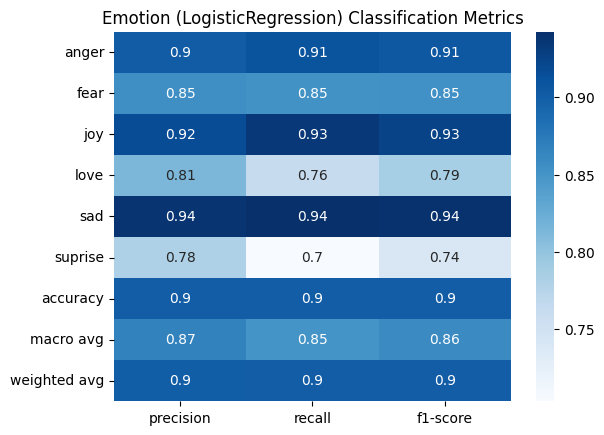

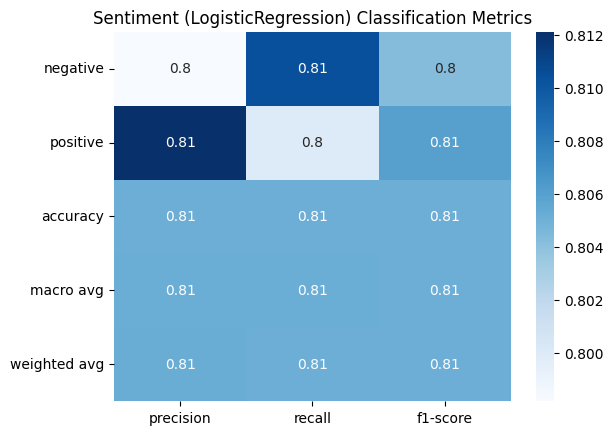

In [ ]:
def plot_metrics(y_test, y_pred, title):
    report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).iloc[:-1, :].T
    sns.heatmap(report, annot=True, cmap="Blues")
    plt.title(title)
    plt.show()

plot_metrics(y_test_emotion, y_pred_emotion, "Emotion (LogisticRegression) Classification Metrics")
plot_metrics(y_test_sentiment, y_pred_sentiment, "Sentiment (LogisticRegression) Classification Metrics")


Бинарная классификация для sentiment_data

In [ ]:
sentiment_model, y_test_sentiment, y_pred_sentiment = train_model(sentiment_data, 'sentiment', SVC(probability=True, random_state=21, kernel='rbf'))

sentiment Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.82      0.82       327
    positive       0.82      0.82      0.82       335

    accuracy                           0.82       662
   macro avg       0.82      0.82      0.82       662
weighted avg       0.82      0.82      0.82       662

Accuracy_score: 0.8187311178247734


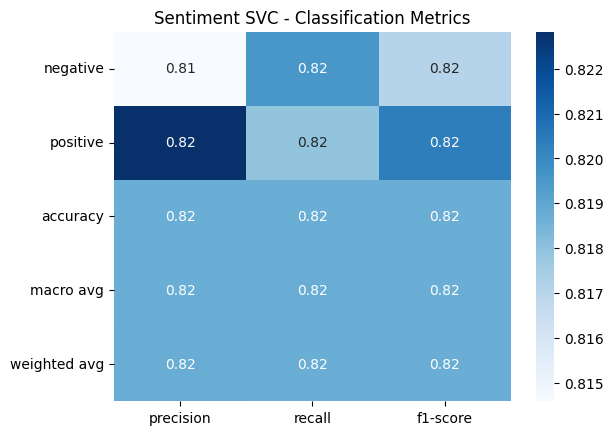

In [ ]:
plot_metrics(y_test_sentiment, y_pred_sentiment, "Sentiment SVC - Classification Metrics")

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVC": SVC(),
    "Random Forest": RandomForestClassifier()
}


In [ ]:
for model_name, model in models.items():
    print(f"\nTraining {model_name} for Sentiment Classification")
    train_model(sentiment_data, 'sentiment', model)


Training Logistic Regression for Sentiment Classification
sentiment Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.81      0.80       327
    positive       0.81      0.80      0.81       335

    accuracy                           0.81       662
   macro avg       0.81      0.81      0.81       662
weighted avg       0.81      0.81      0.81       662

Accuracy_score: 0.8051359516616314

Training SVC for Sentiment Classification
sentiment Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.80      0.80       327
    positive       0.81      0.81      0.81       335

    accuracy                           0.81       662
   macro avg       0.81      0.81      0.81       662
weighted avg       0.81      0.81      0.81       662

Accuracy_score: 0.8051359516616314

Training Random Forest for Sentiment Classification
sentiment Classification Report:
              precisio

# 5. Выводы

**По результатам работы (по accuracy score) наилучшей моделью для классификации sentiment_data является SVC, а для emotion_data LogisticRegression**